In [16]:
import json
import pandas as pd
import torch.nn as nn
import torch
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, Dataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
jsonl_file_path = '/content/drive/My Drive/concat_scrapped_uw_data.jsonl'



In [19]:
# Hyperparameters
input_size = 33 * 3  # 33 joints * 3 coordinates
hidden_size = 256
output_size = 50000 # Assuming a vocabulary size of 66
embedding_size = 256  # Make embedding size equal to hidden_size for simplicity
SOS_token = 0  # Start-of-Sequence token

In [20]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1}
        self.word2count = {"SOS": 0, "EOS": 0}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2   # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

class SignLanguage:
    def __init__(self):
        self.frames = []
        self.max_length = 0

    def addFrames(self, frame_data):
        self.frames.append(frame_data)
        if len(frame_data) > self.max_length:
            self.max_length = len(frame_data)

    def getFrames(self):
        return self.frames


In [21]:
import string

def prepareData(jsonl_file_path, max_samples=1000):
    data = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
            if len(data) >= max_samples:
                break

    def processData(data):
        sign_language = SignLanguage()
        lang_annotations = Lang('pl')
        for item in data:
            sign_language.addFrames(item['FramesLandmarksCoords'])
            lang_annotations.addSentence(item['PolishAnnotation'])
        return sign_language, lang_annotations, [(item['FramesLandmarksCoords'], item['PolishAnnotation']) for item in data]

    return processData(data)

In [22]:
training_dataset = prepareData(jsonl_file_path, max_samples=6000)

train_sign_language, train_polish_annotations, train_pairs = training_dataset

print(f"Loaded {len(train_pairs)} pairs of sign language frames and Polish annotations.")

Loaded 6000 pairs of sign language frames and Polish annotations.


In [23]:
for i, pair in enumerate(train_pairs[:2]):
    frames, annotation = pair
    print(f"Pair {i + 1}:")
    print(f"Frames: {frames}")
    print(f"Polish Annotation: {annotation}")
    print()

Pair 1:
Frames: [[[0.5779041052, 0.2492183447, -0.3488895595], [0.5834807158, 0.2111477703, -0.318148315], [0.5895072222, 0.2100911736, -0.3185247779], [0.5950466394, 0.2090461999, -0.3187777102], [0.5598374605, 0.2116441578, -0.3491907716], [0.5479804277, 0.2111710459, -0.349391222], [0.535830915, 0.210613519, -0.3494714499], [0.58717978, 0.2198818773, -0.1257000566], [0.5038138032, 0.2226966172, -0.25932917], [0.5824526548, 0.2885786593, -0.2720468938], [0.5569399595, 0.2922128141, -0.3105938435], [0.6067162752, 0.4204445183, 0.0262979474], [0.4217470288, 0.4349859357, -0.231533125], [0.6494319439, 0.7297827005, -0.0287049506], [0.488659054, 0.7571706772, -0.3739229441], [0.5457587242, 0.8117858768, -0.2458641529], [0.5253773332, 0.3882613778, -0.5147576332], [0.509224236, 0.8516088128, -0.3058667183], [0.5231071115, 0.3472401798, -0.5785770416], [0.4952027202, 0.8154726624, -0.2913900316], [0.5088750124, 0.3288276494, -0.5811349154], [0.503656745, 0.802161932, -0.2462206781], [0.510

In [24]:
# save_path = '/content/drive/My Drive/Mig-ai/train_dataset_scrapped_uw.json'

In [25]:
# train_pairs_serializable = [(frames, annotation) for frames, annotation in train_pairs]

# # Save the train_pairs to a JSON file
# with open(save_path, 'w', encoding='utf-8') as f:
#     json.dump(train_pairs_serializable, f, ensure_ascii=False, indent=4)

In [26]:
EOS_token = 1

In [27]:
if 'EOS' not in train_polish_annotations.word2index:
    train_polish_annotations.addWord('EOS')

In [28]:
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch
from torch.nn.utils.rnn import pad_sequence
import random

# Assuming EOS_token is defined somewhere
EOS_token = 1  # Example value, adjust according to your EOS token's index

def tensorsFromPair(pair, annotations):
    try:
        flat_list = [coord for frame in pair[0] for landmark in frame for coord in (landmark if isinstance(landmark, list) else [landmark])]
    except TypeError:
        print("Error processing pair:", pair)
        flat_list = []

    if flat_list:
        input_tensor = torch.tensor(flat_list, dtype=torch.float).view(-1, len(flat_list) // len(pair[0]))
    else:
        input_tensor = torch.tensor([], dtype=torch.float).view(-1, 1)

    target_indexes = [annotations.word2index[word] for word in pair[1].split(' ')] + [EOS_token]
    target_tensor = torch.tensor(target_indexes, dtype=torch.long)

    return input_tensor, target_tensor

def get_dataloader(pairs, batch_size, annotations, max_target_length):
    input_tensors = []
    target_tensors = []

    for pair in pairs:
        input_tensor, target_tensor = tensorsFromPair(pair, annotations)
        input_tensors.append(input_tensor)
        # Manually pad target_tensor to max_target_length
        padded_target_tensor = torch.cat([target_tensor, torch.full((max_target_length - target_tensor.size(0),), annotations.word2index['EOS'], dtype=torch.long)])
        target_tensors.append(padded_target_tensor)

    input_tensors_padded = pad_sequence(input_tensors, batch_first=True, padding_value=0)
    target_tensors_padded = torch.stack(target_tensors, dim=0)  # Already manually padded

    dataset = TensorDataset(input_tensors_padded, target_tensors_padded)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

def create_train_test_dataloaders(pairs, batch_size, annotations, split_ratio=0.8):
    # Calculate the maximum target tensor length from all pairs
    max_target_length = max(len(pair[1].split(' ')) for pair in pairs) + 1  # +1 for EOS_token

    # Split the dataset
    dataset_size = len(pairs)
    train_size = int(dataset_size * split_ratio)
    test_size = dataset_size - train_size
    train_pairs, test_pairs = random_split(pairs, [train_size, test_size])

    # Create DataLoader for each subset, now passing max_target_length
    train_loader = get_dataloader(list(train_pairs), batch_size, annotations, max_target_length)
    test_loader = get_dataloader(list(test_pairs), batch_size, annotations, max_target_length)

    return train_loader, test_loader

# Example usage:
# Assuming 'train_pairs' is your dataset and 'annotations' is initialized with a 'word2index' mapping
batch_size = 64
train_loader, test_loader = create_train_test_dataloaders(train_pairs, batch_size, train_polish_annotations)


In [29]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # Applying dropout to the input might not be directly applicable if input is continuous.
        # Consider applying dropout after GRU if needed or using it in a different manner.
        output, hidden = self.gru(input)
        return output, hidden

In [30]:
MAX_LEN = 0

for input_tensor, target_tensor in train_loader:
    if target_tensor.size()[1] > MAX_LEN:
        MAX_LEN = target_tensor.size()[1]

In [31]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LEN):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None and i < target_tensor.size(1) - 1:
            # Teacher forcing: Feed the target as the next input, ensuring we don't exceed target_tensor's length
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [32]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        query = query.float()
        keys = keys.float()
        scores = self.Va(torch.tanh(self.Wa(query.expand(-1, keys.size(1), -1)) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LEN):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [33]:
input_size = 33 * 3  # Assuming each frame is represented by 33 landmarks, each with 3 coordinates
hidden_size = 256  # Example hidden size, adjust based on model complexity and dataset
output_size = len(train_polish_annotations.word2index)
dropout_p = 0.1  # Dropout probability

encoder = EncoderRNN(input_size, hidden_size, dropout_p).to(device)
decoder = AttnDecoderRNN(hidden_size, output_size, dropout_p).to(device)

# Example of model initialization
print(encoder)
print(decoder)

EncoderRNN(
  (gru): GRU(99, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
AttnDecoderRNN(
  (embedding): Embedding(12017, 256)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=256, out_features=256, bias=True)
    (Ua): Linear(in_features=256, out_features=256, bias=True)
    (Va): Linear(in_features=256, out_features=1, bias=True)
  )
  (gru): GRU(512, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=12017, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [34]:
import random

def decode_sentence(indices, lang):
    return ' '.join([lang.index2word.get(index, '') for index in indices if index not in (EOS_token,)])

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder.train()
    decoder.train()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Compute loss
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy excluding padding
        _, predicted = decoder_outputs.max(-1)  # Get the index of the max log-probability
        non_padding_mask = target_tensor != EOS_token
        correct = (predicted == target_tensor) & non_padding_mask  # Apply mask
        num_correct = correct.sum().item()
        total_samples += non_padding_mask.sum().item()  # Count non-padding values only

        total_correct += num_correct

    # Select a random example from the last batch processed for printing
    example_index = random.randint(0, input_tensor.size(0) - 1)  # Randomly select an index
    predicted_example = predicted[example_index]
    target_example = target_tensor[example_index]

    predicted_sentence = decode_sentence(predicted_example[predicted_example != EOS_token].cpu().numpy(), train_polish_annotations)
    target_sentence = decode_sentence(target_example[target_example != EOS_token].cpu().numpy(), train_polish_annotations)

    print("Predicted sentence:", predicted_sentence)
    print("Target sentence:", target_sentence)

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples if total_samples > 0 else 0

    return average_loss, accuracy


In [35]:
encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.0001)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.0001)
criterion = nn.NLLLoss(ignore_index=train_polish_annotations.word2index['EOS']).to(device)


In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlots(losses, train_accuracies, test_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Creates a figure with two subplots side by side

    # Plot for Losses
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Training Loss')

    # Plot for Accuracies
    color_train = 'tab:blue'
    color_test = 'tab:green'
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.plot(train_accuracies, color=color_train, label='Train Accuracy')
    ax2.plot(test_accuracies, color=color_test, label='Test Accuracy')
    ax2.tick_params(axis='y')
    ax2.legend()
    ax2.set_title('Training & Testing Accuracy')

    fig.tight_layout()  # Adjusts the layout so that labels don't overlap
    plt.show()

In [37]:
def evaluate(dataloader, encoder, decoder, criterion):

    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            total_loss += loss.item()

            # Calculate accuracy excluding padding
            _, predicted = decoder_outputs.max(-1)  # Get the index of the max log-probability
            non_padding_mask = target_tensor != EOS_token
            correct = (predicted == target_tensor) & non_padding_mask  # Apply mask
            num_correct = correct.sum().item()
            total_samples += non_padding_mask.sum().item()  # Count non-padding values only

            total_correct += num_correct

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples if total_samples > 0 else 0

    return average_loss, accuracy

In [38]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def train(train_dataloader, test_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    print_acc_total = 0
    train_accuracies = []
    test_accuracies = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss().to(device)

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        print_acc_total += accuracy
        plot_loss_total += loss
        train_accuracies.append(accuracy * 100)  # Assuming accuracy is a fraction, convert to percentage


        test_loss, test_accuracy = evaluate(test_dataloader, encoder, decoder, criterion)
        test_accuracies.append(test_accuracy * 100)

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_acc_avg = print_acc_total / print_every
            print_loss_total = 0
            print_acc_total = 0
            print('%s (%d %d%%) Train Loss: %.4f Train Acc: %.2f%% Test Loss: %.4f Test Acc: %.2f%%' % (timeSince(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg, print_acc_avg * 100, test_loss, test_accuracy * 100))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    print(plot_losses)
    showPlots(plot_losses, train_accuracies, test_accuracies)


Predicted sentence: W
Target sentence: Bierze kamień i rzuca nim w szybę, która pęka.
1m 2s (- 82m 25s) (1 1%) Train Loss: 1.4445 Train Acc: 0.41% Test Loss: 0.9736 Test Acc: 0.62%
Predicted sentence: Nie
Target sentence: Ślisko.
2m 6s (- 82m 31s) (2 2%) Train Loss: 0.9528 Train Acc: 0.94% Test Loss: 0.9600 Test Acc: 2.18%
Predicted sentence: Nie
Target sentence: Jest dobrze, to kino.
3m 11s (- 82m 1s) (3 3%) Train Loss: 0.9124 Train Acc: 2.11% Test Loss: 0.9462 Test Acc: 3.31%
Predicted sentence: W jest na w głowie i
Target sentence: Kot patrzy przez lornetkę na drugi dom, jego oczy robią się czerwone z wściekłości.
4m 16s (- 81m 18s) (4 5%) Train Loss: 0.8728 Train Acc: 3.18% Test Loss: 0.9317 Test Acc: 4.05%
Predicted sentence: Nie się głowie kosza.
Target sentence: Wyjeżdżam na wycieczkę do Olsztyna.
5m 21s (- 80m 28s) (5 6%) Train Loss: 0.8312 Train Acc: 4.24% Test Loss: 0.9229 Test Acc: 4.95%
Predicted sentence: Nie wolno.
Target sentence: Nie mogę.
6m 26s (- 79m 31s) (6 7%) Trai

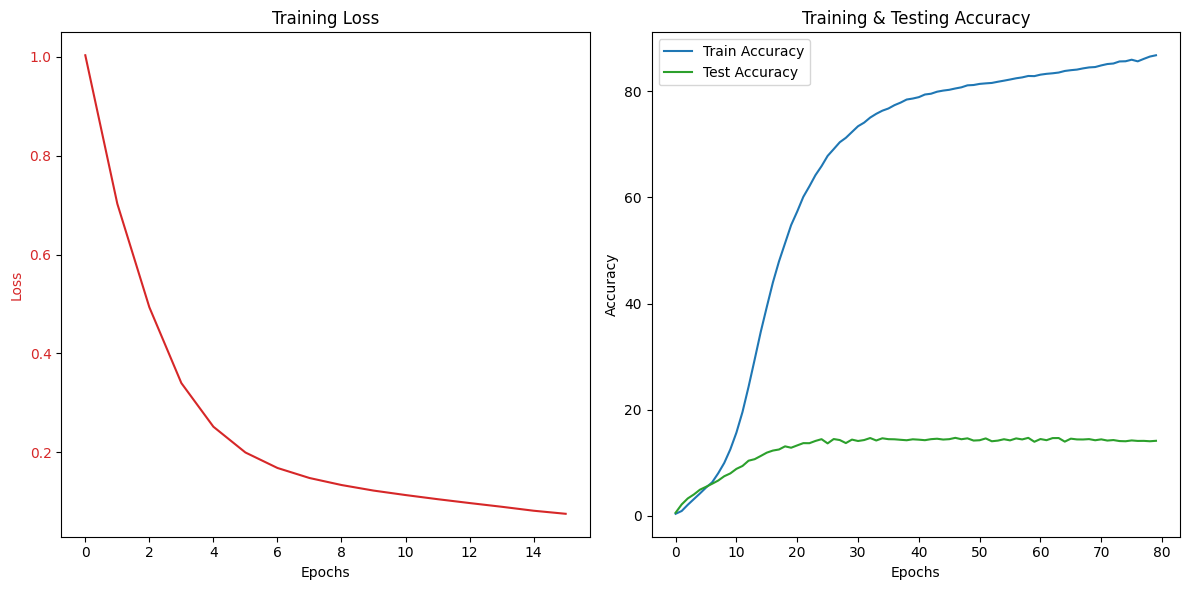

In [39]:
train(train_loader,test_loader, encoder, decoder, 80, print_every=1, plot_every=5)

In [40]:
from nltk.translate.bleu_score import corpus_bleu

In [41]:
def evaluate_bleu(dataloader, encoder, decoder, lang):
    predictions = []
    references = []

    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            _, predicted = decoder_outputs.max(-1)

            for i in range(predicted.size(0)):
                predicted_sentence = decode_sentence(predicted[i][predicted[i] != EOS_token].cpu().numpy(), lang)
                target_sentence = decode_sentence(target_tensor[i][target_tensor[i] != EOS_token].cpu().numpy(), lang)

                predictions.append(predicted_sentence.split())
                references.append([target_sentence.split()])

    bleu_score = corpus_bleu(references, predictions)
    return bleu_score

In [42]:
train_bleu_score = evaluate_bleu(train_loader, encoder, decoder, train_polish_annotations)

print(f"Train BLEU: {train_bleu_score:.2f}")

Train BLEU: 0.85
